In [1]:
import os
import os.path

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision.datasets.utils import makedir_exist_ok
import torchaudio

import pandas as pd
import numpy as np

import librosa

import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 64

In [4]:
a = np.array([1., 2., 3.])
b = np.array([4., 5., 6.])

c = np.hstack([a, b])
print(c)

[1. 2. 3. 4. 5. 6.]


In [5]:
class UrbanSound8K(Dataset):

    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = [
                (0, 'air_conditioner'),
                (1, 'car_horn'),
                (2, 'children_playing'),
                (3, 'dog_bark'),
                (4, 'drilling'),
                (5, 'engine_idling'),
                (6, 'gun_shot'),
                (7, 'jackhammer'),
                (8, 'siren'),
                (9, 'street_music')
            ]
    
    def __init__(self, root, train=True, fold_list=None, 
                       transform=None, target_transform=None, require_preprocess=True):
        
        super(UrbanSound8K, self).__init__()
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
    
        if require_preprocess:
            self.preprocess(fold_list)

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        
        if self._check_exists(os.path.join(self.processed_folder, data_file)):
            self._read_metadata(fold_list)
            self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))
        else:
            raise RuntimeError('Dataset not found. (%s)' % 
                                   os.path.join(self.processed_folder, data_file))
    
    def __getitem__(self, index):
        
        sound, target = self.data[index], int(self.targets[index])
        
        if self.transform is not None:
            sound = self.transform(sound)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sound, target
    
    def __len__(self):
        return len(self.data)
    
    @property
    def audio_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'audio')
    
    @property
    def metadata_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'metadata')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')
    
    @property
    def class_to_idx(self):
        return {_class: i for i, (cid, _class) in enumerate(self.classes)}
    
    @property
    def idx_to_class(self):
        return {i: _class for i, (cid, _class) in enumerate(self.classes)}
    
    def _check_exists(self, file):
        return os.path.exists(file)
    
    def _read_metadata(self, fold_list):
        csv_path = os.path.join(self.metadata_folder, self.__class__.__name__+".csv")
        
        self.metadata = {}
        file_names = []
        labels = []
        folders = []
        
        if os.path.exists(csv_path):
            csvData = pd.read_csv(csv_path)
            
            for i in range(0,len(csvData)):
                if csvData.iloc[i, 5] in fold_list:
                    file_names.append(csvData.iloc[i, 0])
                    labels.append(csvData.iloc[i, 6])
                    folders.append(csvData.iloc[i, 5])
            
            self.metadata['file_names'] = file_names
            self.metadata['labels'] = labels
            self.metadata['folders'] = folders
        else:
            raise RuntimeError('Metadata(csv format) not found.')
    
    def preprocess(self, fold_list):
        
        makedir_exist_ok(self.audio_folder)
        makedir_exist_ok(self.processed_folder)
        
        self._read_metadata(fold_list)
        
        # pre-process
        file_names = self.metadata['file_names']
        labels = self.metadata['labels']
        folders = self.metadata['folders']
        
        data = []
        targets = []
        
        start = time.time()
        for idx, (file_name, label, folder) in enumerate(zip(file_names, labels, folders)):
            wav_file_path = os.path.join(self.audio_folder, 
                                         "fold{}".format(folder), 
                                         file_name)
            
            sound, sr= librosa.load(wav_file_path, mono=True, res_type='kaiser_fast')

#             # 4초 임시데이터 생성
#             tempSound = torch.zeros(4*8000) # 4sec. * 8KHz
#             if len(sound) < 4*8000:
#                 tempSound[:len(sound)] = torch.FloatTensor(sound[:])
#             else:
#                 tempSound[:] = torch.FloatTensor(sound[:4*8000])

#             sound = tempSound
            target = label
            
#             frame_length = 0.025                        # 25(ms)
#             frame_stride = 0.010                        # 10(ms)
#             n_fft = int(round(sr*frame_length))        # 200 (sample)
#             hop_length = int(round(sr*frame_stride))    # 80 (sample)
            
            X, sample_rate = sound, sr
        
            # stft = np.abs(librosa.stft(X))
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            # chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            # mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            # contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            # tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            
            melspec = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=40)
            
            # logspec = np.log(melspec)
            logspec = librosa.power_to_db(melspec, ref=np.max)
            log_mel = np.mean(logspec.T, axis=0)
            
            
            # S = np.hstack([mfccs, chroma, mel, contrast])
            S = np.hstack([log_mel])
            
            # S = np.mean(librosa.feature.melspectrogram(y=sound, n_mels=40, n_fft=n_fft, hop_length=hop_length).T, axis=0)
            # mfccs = np.mean(librosa.feature.mfcc(y=sound.numpy(), sr=sr, n_mfcc=40).T, axis=0)
            
            # print(S.shape, S)
            # print(mfccs.shape, mfccs)
            # break
 
            S = torch.FloatTensor(S)
            
            data.append(S)
            targets.append(target)
            
            end = time.time()
            if idx % 100 == 0:
                print("(%s) %04d/%04d processed. (%.4f (sec.))" % ("train" if self.train else "test", idx+1, len(file_names), (end-start)))
        
        
        if self.train:
            training_set = (
                torch.stack(data),
                torch.LongTensor(targets)
            )
            
            with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
                torch.save(training_set, f)
        else:
            test_set = (
                torch.stack(data),
                torch.LongTensor(targets)
            )
            
            with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
                torch.save(test_set, f)

        print('Done!')
        

In [6]:
# urbansound8k dataset
start = time.time()
urbansound8k_train = UrbanSound8K(root='../data/UrbanSound8K_data',
                                  train=True,
                                  fold_list=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                                  require_preprocess=False)
end = time.time()
print("Prepare (Train Data Set): %.4f (sec.)" % (end-start))

# urbansound8k dataset
start = time.time()
urbansound8k_test = UrbanSound8K(root='../data/UrbanSound8K_data',
                                 train=False,
                                 fold_list=[10],
                                 require_preprocess=False)
end = time.time()
print("Prepare (Test Data Set): %.4f (sec.)" % (end-start))

train_loader = torch.utils.data.DataLoader(dataset=urbansound8k_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

Prepare (Train Data Set): 0.4868 (sec.)
Prepare (Test Data Set): 0.1567 (sec.)


In [7]:
# Linear modeling
linear1 = torch.nn.Linear(40, 256, bias=True) # 193
linear2 = torch.nn.Linear(256, 256, bias=True)
linear3 = torch.nn.Linear(256, 256, bias=True)
linear4 = torch.nn.Linear(256, 256, bias=True)
linear5 = torch.nn.Linear(256, 10, bias=True)
relu = torch.nn.ReLU()

drop_prob = 0.5
dropout = torch.nn.Dropout(p=drop_prob)

bn1 = torch.nn.BatchNorm1d(256)
bn2 = torch.nn.BatchNorm1d(256)
bn3 = torch.nn.BatchNorm1d(256)
bn4 = torch.nn.BatchNorm1d(256)

In [8]:
# Initialization
# torch.nn.init.normal_(linear.weight)

# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0913, -0.0321,  0.1372,  ...,  0.0637, -0.1191, -0.0576],
        [-0.0012,  0.0804, -0.1444,  ..., -0.1163,  0.0515,  0.1235],
        [-0.0349, -0.1381,  0.0964,  ..., -0.1455, -0.0198,  0.1267],
        ...,
        [ 0.0869, -0.0087,  0.1309,  ..., -0.1093,  0.0397,  0.1213],
        [-0.0861,  0.1246,  0.0974,  ..., -0.0809, -0.0530,  0.0662],
        [ 0.0316,  0.0907,  0.0802,  ...,  0.1502, -0.0920,  0.0442]],
       requires_grad=True)

In [9]:
# model
model = torch.nn.Sequential(linear1, bn1, relu, dropout,
                            linear2, bn2, relu, dropout,
                            linear3, bn3, relu, dropout,
                            linear4, bn4, relu, dropout,
                            linear5).to(device)

In [10]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [11]:
# model.reset_parameters()

training_epochs = 10

total_batch = len(train_loader)
print(total_batch)

model.train()    # set the model to train mode (dropout=True)
for epoch in range(training_epochs):
    avg_cost = 0
    
    costs = []
    for iter_id, (X, Y) in enumerate(train_loader):
        start = time.time()
        
        X = X.view(-1, 40).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
        costs.append(cost.item())
        mean_costs = np.mean(np.array(costs))
        
        end = time.time()
        e_time_sec = (end - start)
#         print('Epoch:', '%04d' % (epoch + 1), 
#               'Iter:', '%03d/%03d' % (iter_id + 1, total_batch), 
#               'cost =', '{:.9f}'.format(mean_costs),
#               'Time:', '%.4f (sec.)' % e_time_sec)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    
    with torch.no_grad():
        model.eval()    # set the model to evaluation mode (dropout=False)
        
        
        X_train = urbansound8k_train.data.view(-1, 40).to(device)
        Y_train = urbansound8k_train.targets.to(device)
        
        prediction = model(X_train)

        correct_prediction = torch.argmax(prediction, 1) == Y_train
        accuracy = correct_prediction.float().mean()
        print('(Train) Accuracy:', accuracy.item())
        
        ############################################
        
        X_test = urbansound8k_test.data.view(-1, 40).to(device)
        Y_test = urbansound8k_test.targets.to(device)

        prediction = model(X_test)

        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        print('(Test ) Accuracy:', accuracy.item())

print('Learning finished')

123
Epoch: 0001 cost = 2.062075377
(Train) Accuracy: 0.3936668634414673
(Test ) Accuracy: 0.3608124256134033
Epoch: 0002 cost = 1.449234724
(Train) Accuracy: 0.50563645362854
(Test ) Accuracy: 0.4504181742668152
Epoch: 0003 cost = 1.283504367
(Train) Accuracy: 0.4862571358680725
(Test ) Accuracy: 0.5113500356674194
Epoch: 0004 cost = 1.289353848
(Train) Accuracy: 0.5611146092414856
(Test ) Accuracy: 0.48028674721717834
Epoch: 0005 cost = 1.224193096
(Train) Accuracy: 0.5675744414329529
(Test ) Accuracy: 0.48745518922805786
Epoch: 0006 cost = 1.213917255
(Train) Accuracy: 0.5741608738899231
(Test ) Accuracy: 0.5125448107719421
Epoch: 0007 cost = 1.222190380
(Train) Accuracy: 0.5768207907676697
(Test ) Accuracy: 0.5495818257331848
Epoch: 0008 cost = 1.188686252
(Train) Accuracy: 0.6148195266723633
(Test ) Accuracy: 0.5686977505683899
Epoch: 0009 cost = 1.186166525
(Train) Accuracy: 0.6165927648544312
(Test ) Accuracy: 0.5651134848594666
Epoch: 0010 cost = 1.150431752
(Train) Accuracy: 0.

Accuracy: 0.49940264225006104
Random One:  589
Label:  1 car_horn
Prediction:  1 car_horn
../data/UrbanSound8K_data/UrbanSound8K/audio/fold10/28808-1-0-0.wav
(837,) <class 'numpy.ndarray'> 9 <class 'numpy.int64'>
(837,) <class 'numpy.ndarray'> 1 <class 'numpy.int64'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[41  0  7  0  0 20  0 30  2  0]
 [ 0 20  0  0  6  5  0  1  0  1]
 [10  0 32 17  1 15  1  2 15  7]
 [ 4  0 14 57  3  7  0  3  8  4]
 [ 5  0  0  0 54 16  0 14 10  1]
 [14  0  0  2  6 67  0  3  0  1]
 [ 0  0  2 22  0  0  4  0  4  0]
 [ 1  0  3  0 14  9  0 69  0  0]
 [16  0 13  0  3  8  0  1 41  1]
 [25  2 18  1 10  4  0  1  6 33]]
<class 'numpy.ndarray'> [0 1 2 3 4 5 6 7 8 9]
Confusion matrix, without normalization
[[41  0  7  0  0 20  0 30  2  0]
 [ 0 20  0  0  6  5  0  1  0  1]
 [10  0 32 17  1 15  1  2 15  7]
 [ 4  0 14 57  3  7  0  3  8  4]
 [ 5  0  0  0 54 16  0 14 10  1]
 [14  0  0  2  6 67  0  3  0  1]
 [ 0  0  2 22  0  0  4  0  4  0]
 [ 1  0  3  0 14  9  0 69  0  0]
 [16  0 13  0  3  8 

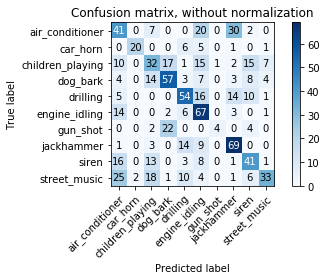

In [20]:
# Test the model using test sets
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)
    
    X_test = urbansound8k_test.data.view(-1, 40).to(device)
    Y_test = urbansound8k_test.targets.to(device)
    
    prediction = model(X_test)
    
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    
    # Get one and predict
    r = random.randint(0, len(urbansound8k_test) - 1)
    print('Random One: ', r)
    X_single_data = urbansound8k_test.data[r:r + 1].view(-1, 40).to(device)
    Y_single_data = urbansound8k_test.targets[r:r + 1].to(device)

    print('Label: ', Y_single_data.item(), 
                     urbansound8k_test.idx_to_class[Y_single_data.item()])
    
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item(), 
                          urbansound8k_test.idx_to_class[torch.argmax(single_prediction, 1).item()])
    
    
    folder = urbansound8k_test.metadata['folders'][r]
    file_name = urbansound8k_test.metadata['file_names'][r]
    wav_file_path = os.path.join(urbansound8k_test.audio_folder, 
                                 "fold{}".format(folder), 
                                 file_name)
    print(wav_file_path)
    
    # import IPython.display as ipd
    # ipd.Audio(wav_file_path) # load a local WAV file
    
    y_pred = torch.argmax(prediction, 1).numpy()
    y_true = Y_test.numpy()
    
    print(y_pred.shape, type(y_pred), y_pred[0], type(y_pred[0]))
    print(y_true.shape, type(y_true), y_true[0], type(y_true[0]))
    
    labels = [cid for cid, _class in urbansound8k_test.classes]
    print(labels)
    
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y_true, y_pred, labels=labels))
    
    # Plot non-normalized confusion matrix
    class_names = np.array([_class for cid, _class in urbansound8k_test.classes])
    plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
    

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(type(unique_labels(y_true, y_pred)), unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [21]:
print(wav_file_path)

import IPython.display as ipd
ipd.Audio(wav_file_path) # load a local WAV file

../data/UrbanSound8K_data/UrbanSound8K/audio/fold10/28808-1-0-0.wav


In [32]:
!ls -al "../data/UrbanSound8K_data/UrbanSound8K/audio/fold1/118279-8-0-5.wav"

-rw------- 1 1829600028 1829600028 768044  5월 20  2014 ../data/UrbanSound8K_data/UrbanSound8K/audio/fold1/118279-8-0-5.wav


In [16]:
import librosa
import time

file_name = "../data/UrbanSound8K_data/UrbanSound8K/audio/fold1/119455-5-0-0.wav"

audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
print(audio.shape, sample_rate)

mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

print(mfccs.shape, mfccs)

mfccsscaled = np.mean(mfccs.T,axis=0)

print(mfccsscaled.shape, mfccsscaled)

(88200,) 22050
(40, 173) [[-162.89 -169.34 -195.61 ... -178.88 -162.08 -140.64]
 [  84.38   98.61   98.84 ...   90.64   80.37   77.33]
 [ -15.26   -3.68    5.72 ...    5.94   -1.01   -3.  ]
 ...
 [   5.2     3.27    0.27 ...   -3.14    7.4    12.38]
 [  -6.12   -5.24   -6.39 ...   -5.71    0.96    1.37]
 [  -2.31   -0.47    1.78 ...   -4.79    2.83    0.49]]
(40,) [-170.43   88.7     8.11   24.52  -29.19   20.53  -11.41   25.65  -10.13
   15.99   -4.9    17.76   -1.43   14.59    2.48   17.98   -5.43   14.13
   -2.02   11.69   -3.58   -2.85   -8.11   -1.62   -2.27   -1.78   -7.6
   -3.78   -2.12   -1.97   -7.52   -1.63  -10.78   -7.19   -4.76   -6.41
   -5.79   -0.45   -5.45   -0.29]
